In [1]:
import os
import torch 
import torchvision
from torch import nn
import matplotlib.pyplot as plt

In [2]:
# Define the ResNet-18 model
import torchvision.models as models
net = models.resnet18(num_classes=10)

In [3]:
#collect data 
data_path = './data' #Path of the Data!
all_images  = torchvision.datasets.CIFAR10(train = True, root = data_path, download = True)

Files already downloaded and verified


In [4]:
def show_images(images, rows, cols, scale=1):
    """Plot set of images"""
    fig, axes = plt.subplots(rows, cols)
    fig.set_size_inches(cols*scale, rows*scale)
    for i in range(rows*cols):
        ax = axes[i//cols, i%cols]
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

In [5]:
#select first 32 images
images_to_show = [all_images[i][0] for i in range(32)]

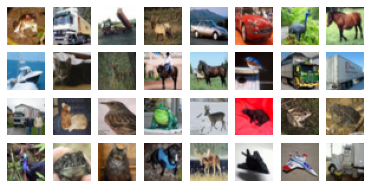

In [6]:
show_images(images_to_show, 4,8,0.8)

In [7]:
# For data augmentation we'll apply RandomHorizontalFlip()
train_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_aug = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [15]:
def load_cifar10(is_train, augs, batch_size):
    """ Load Data, apply augmentation and return dataloader """
    dataset = torchvision.datasets.CIFAR10(
        train = is_train, root = data_path, transform = augs, download = True #apply augmentation
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, #batch_size required for Gradient and updating in Neural Network
                                             shuffle = is_train, num_workers = os.cpu_count())
    return dataloader #we return an iterable dataloader object

In [23]:
def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else :
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    output = net(X)
    l = loss(output, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = (output.argmax(dim=1) == y).sum()
    return train_loss_sum, train_acc_sum

In [27]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # transfer model to GPUs
    for epoch in range(num_epochs):
        metrics = [0.0,0.0]
        num_examples = 0
        for X, y in train_iter:
            train_loss_sum , train_acc_sum = train_batch(net, X, y, loss, trainer, devices)
            num_examples += y.shape[0]
            metrics[0] += train_loss_sum
            metrics[1] += train_acc_sum
        train_loss = metrics[0]/num_examples
        train_acc = metrics[1]/num_examples
        test_acc = evaluate_accuracy(net, test_iter, devices)
        print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def evaluate_accuracy(net, test_iter, devices):
    net.eval()
    metrics = [0.0, 0]
    for X, y in test_iter:
        X, y = X.to(devices[0]), y.to(devices[0])
        output = net(X)
        metrics[0] += (output.argmax(dim=1) == y).sum()
        metrics[1] += y.shape[0]
    return metrics[0]/metrics[1]

In [21]:
batch_size = 256
learning_rate = 0.001
devices = [torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')]
train_iter = load_cifar10(True, train_aug, batch_size)
test_iter = load_cifar10(False, test_aug, batch_size)
loss = nn.CrossEntropyLoss(reduction = 'none')
trainer = torch.optim.Adam(net.parameters(), lr = learning_rate)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
train(net, train_iter, test_iter, loss, trainer,10, devices)

Epoch 10, Loss: 0.3318, Train Acc: 0.8848, Test Acc: 0.7183
